# Load Necessary Library


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

2024-08-09 06:34:20.701403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 06:34:20.701519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 06:34:20.846700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the Dataset

In [2]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1
)

path = '/kaggle/input/alpr-character-train/data'
# Load training data
train_generator = train_datagen.flow_from_directory(
    path + '/train',
    target_size=(44, 24),
    color_mode='grayscale',
    class_mode='sparse'  # Ensure this matches your model output
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    path + '/val',
    target_size=(44, 24),
    color_mode='grayscale',
    class_mode='sparse'  # Ensure this matches your model output
)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## Data Preprocessing

In [3]:
validation_generator.labels

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
       19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
       22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28,
       28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33,
       34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35], dtype=int32)

### Plot the first 50 digit with their actual label

In [4]:
# Get class labels from the generator
class_labels = train_generator.class_indices
reverse_class_labels = {v: k.split('_')[-1] for k, v in class_labels.items()}
reverse_class_labels

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z'}

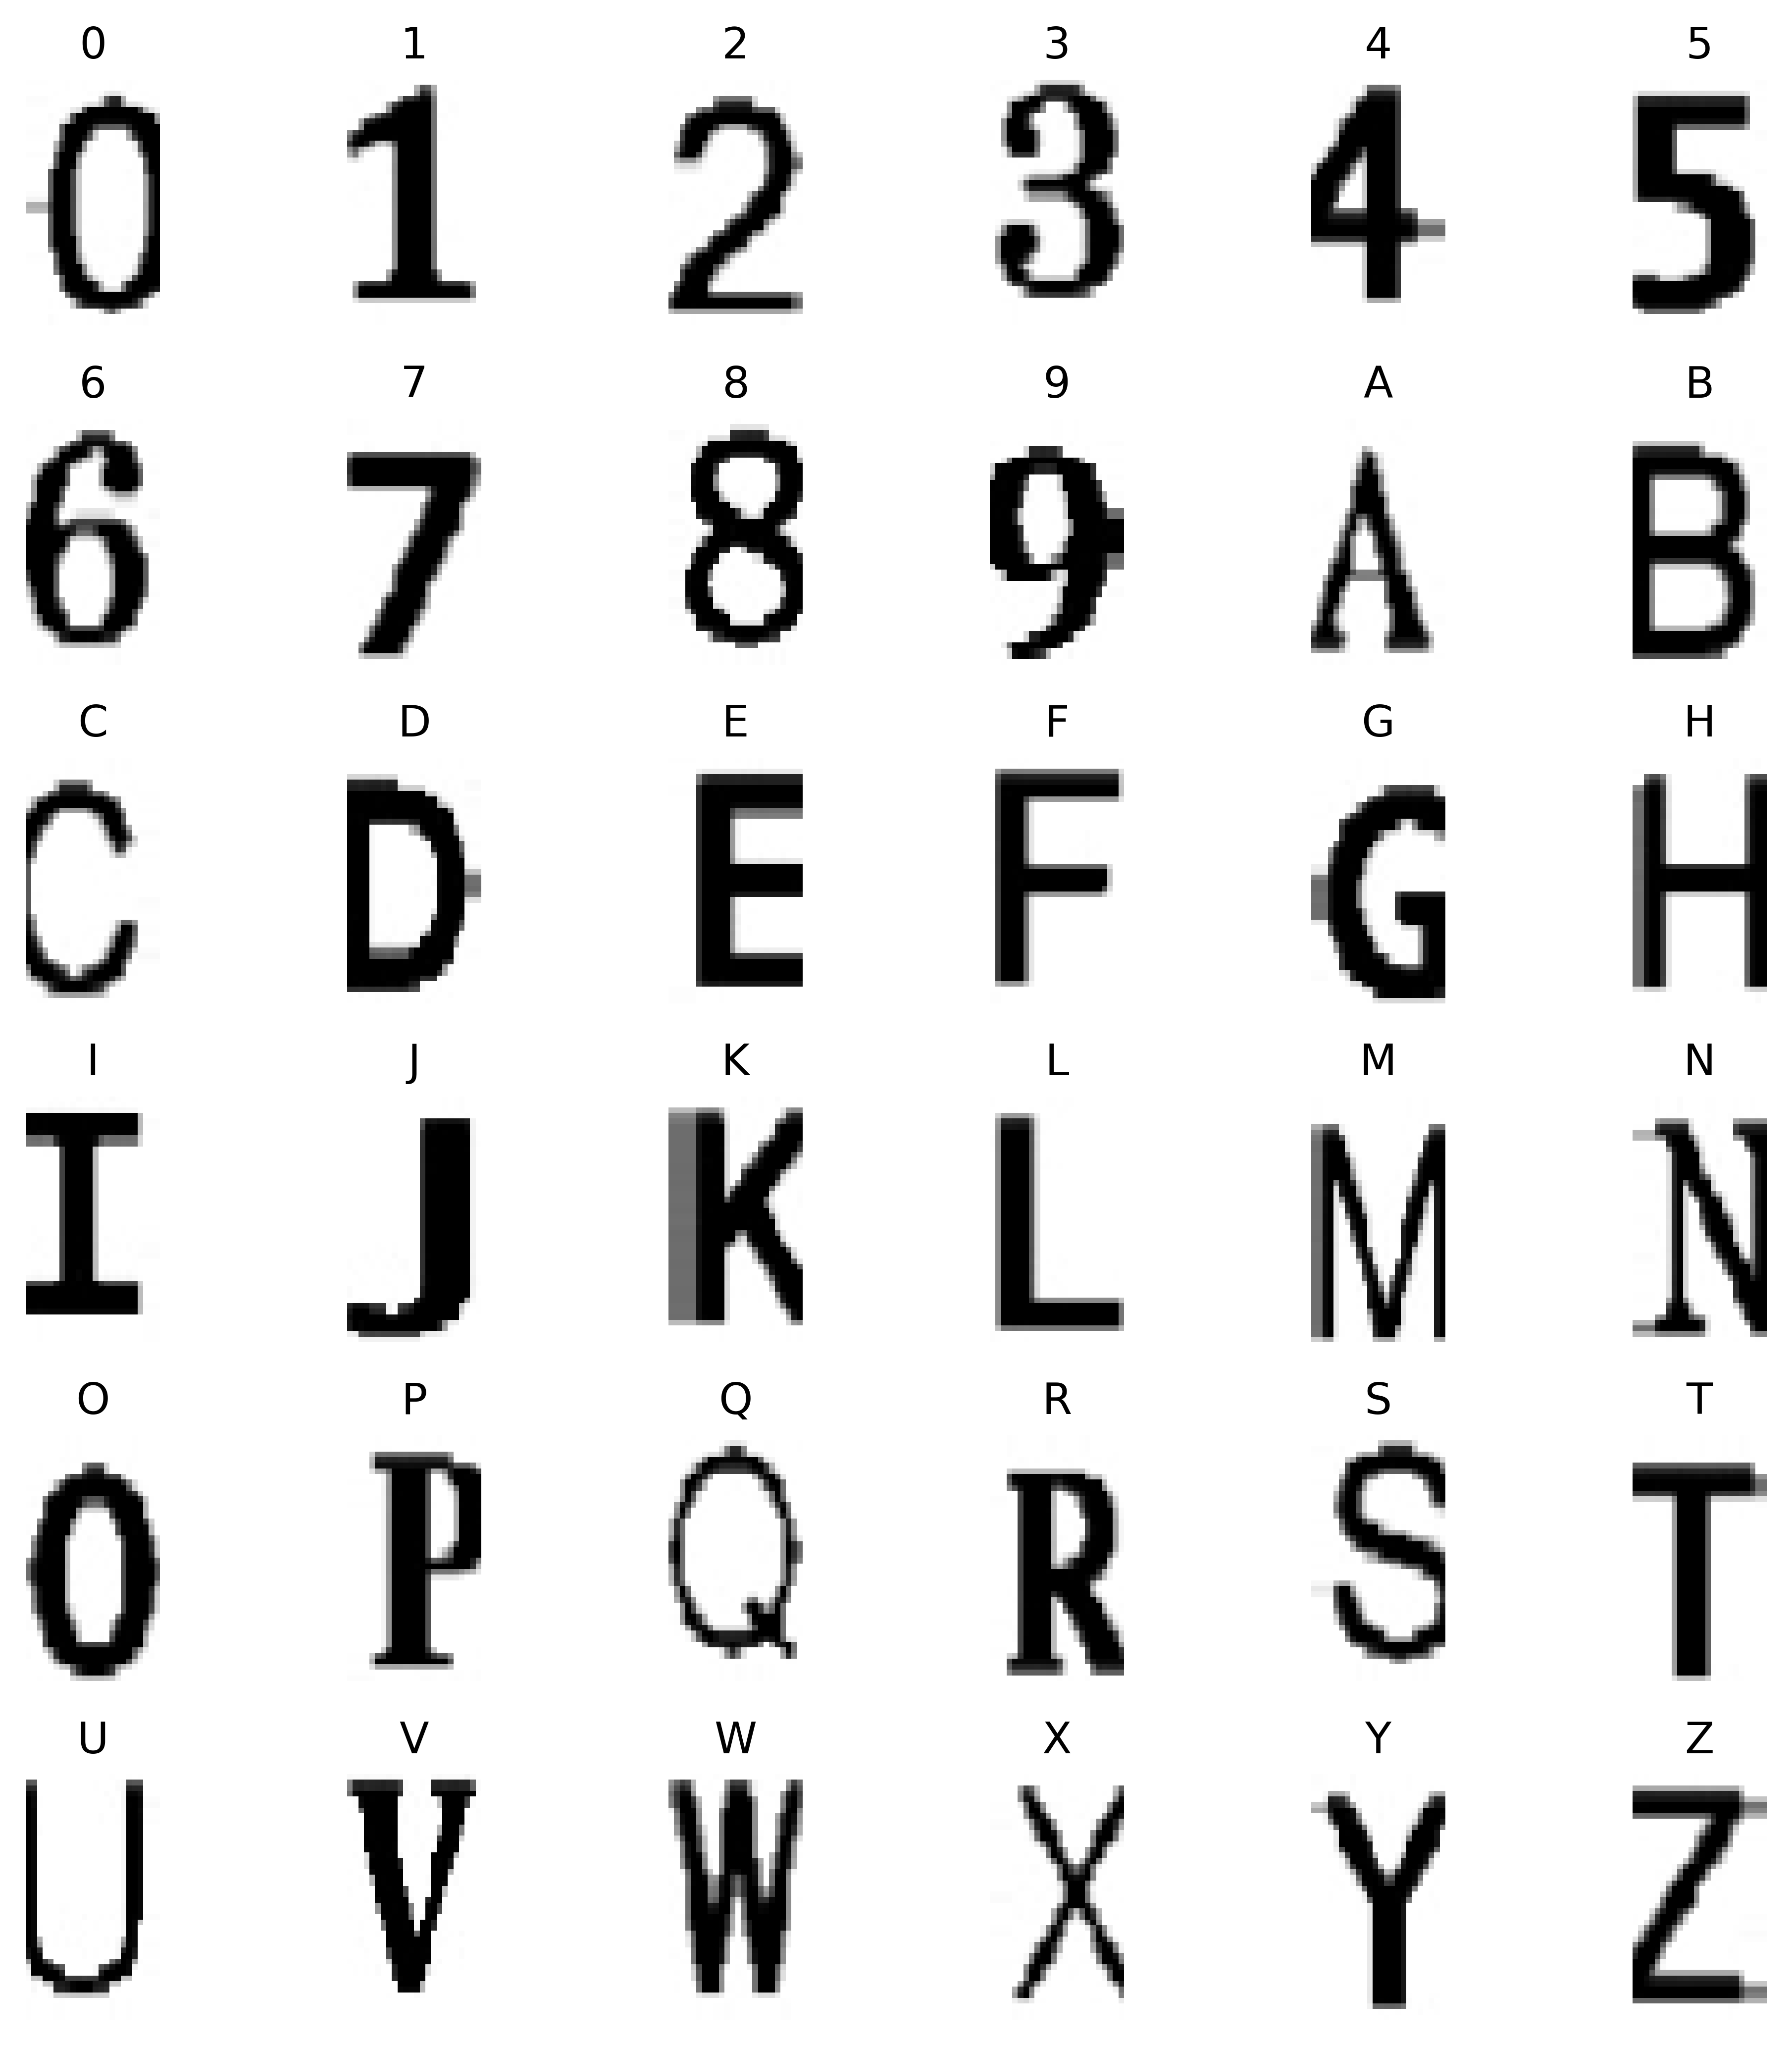

In [5]:
# Collect one image per class
class_images = {}
for images, labels in train_generator:
    for img, label in zip(images, labels):
        label = int(label)
        if label not in class_images:
            class_images[label] = img
        if len(class_images) == len(class_labels):
            break
    if len(class_images) == len(class_labels):
        break

# Plot one image from each class
plt.figure(figsize=(8, 8), dpi=523)
num_classes = len(class_labels)
for i in range(num_classes):
    plt.subplot(6, 6, i + 1)  # Adjust subplot grid size based on number of classes
    img = class_images[i]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(reverse_class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Model Building

In [6]:
def custom_f1score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)  # Convert predictions to class labels
    y_true = tf.cast(y_true, tf.int64)   # Ensure y_true is of int64 type
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_value = precision.result().numpy()
    recall_value = recall.result().numpy()
    f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)  # Add epsilon to avoid division by zero
    return f1_score

In [7]:
# Clear any previous model/session
K.clear_session()

# Build the model
model = Sequential([
    Conv2D(16, (22, 22), activation='relu', padding='same', input_shape=(44, 24, 1)),
    Conv2D(32, (16, 16), activation='relu', padding='same'),
    Conv2D(64, (8, 8), activation='relu', padding='same'),
    Conv2D(128, (4, 4), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(36, activation='softmax')  # Assuming 36 classes
])

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Updated learning_rate argument
    metrics=['accuracy', custom_f1score]  # Ensure custom_f1score is defined
)

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 24, 16)     │         7,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 24, 32)     │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 24, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,325,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,797,396 (18.30 MB)

 Trainable params: 4,797,396 (18.30 MB)

 Non-trainable params: 0 (0.00 B)

#### Choose an optimizer and loss function for training

In [8]:
import tensorflow as tf

# Define the custom callback
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if logs.get('val_custom_f1score') and logs['val_custom_f1score'] > 0.99:
            print(f"\nStopping training as val_custom_f1score reached {logs['val_custom_f1score']:.4f}")
            self.model.stop_training = True

# Define batch size
batch_size = 1

# Define callbacks
callbacks = [StopTrainingCallback()]

#### Compile the model

In [9]:
# Define the loss object correctly
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

In [10]:
model.compile(optimizer=optimizer,loss=loss_object, metrics=['accuracy'])

#### Train the model

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    epochs=200,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/864 ━━━━━━━━━━━━━━━━━━━━ 1:06 77ms/step - accuracy: 0.0260 - loss: 3.5930     

I0000 00:00:1723185286.599007      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 25/864 ━━━━━━━━━━━━━━━━━━━━ 1:19 94ms/step - accuracy: 0.0273 - loss: 3.5925 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


864/864 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0233 - loss: 3.5885 - val_accuracy: 0.0278 - val_loss: 3.5836
Epoch 2/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0230 - loss: 3.5841 - val_accuracy: 0.0278 - val_loss: 3.5835
Epoch 3/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0268 - loss: 3.5839 - val_accuracy: 0.0278 - val_loss: 3.5835
Epoch 4/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0220 - loss: 3.5842 - val_accuracy: 0.0278 - val_loss: 3.5835
Epoch 5/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0384 - loss: 3.5656 - val_accuracy: 0.0602 - val_loss: 3.3155
Epoch 6/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1019 - loss: 3.2504 - val_accuracy: 0.1111 - val_loss: 3.1791
Epoch 7/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2071 - loss: 2.9062 - val_accuracy: 0.2731 - val_loss: 2.5747
Epoch 8/200
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4040 - loss: 2.0000 - val_accuracy: 0.606

## Model Evaluation

In [12]:
loss, accuracy = model.evaluate(validation_generator)

# Print the accuracy
print('The accuracy of the model on unknown data is', round((accuracy * 100), 2), '%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9870 - loss: 0.0872
The accuracy of the model on unknown data is 98.61 %


In [13]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']                        # Accuracy obtained on training data
val_acc = history_dict['val_accuracy']                # Accuracy obtained on Validation data

loss = history_dict['loss']                                  # Losses obtained on training data
val_loss = history_dict['val_loss']                          # Losses obtained on validation data

#### Training and validation loss

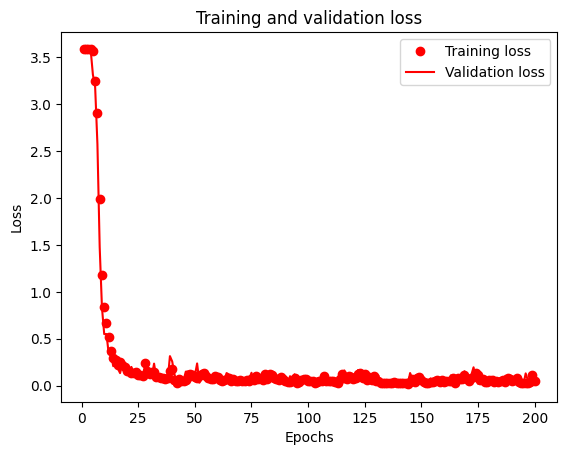

In [14]:
epochs = range(1, len(acc) + 1)                              # Epoch = range(1, 10+1)  10 iterations        

# Training Loss
plt.plot(epochs, loss, 'ro', label='Training loss')          # "ro" is for "red dot"
# Validation Loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')     # r is for "solid red line"

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Training and validation accuracy

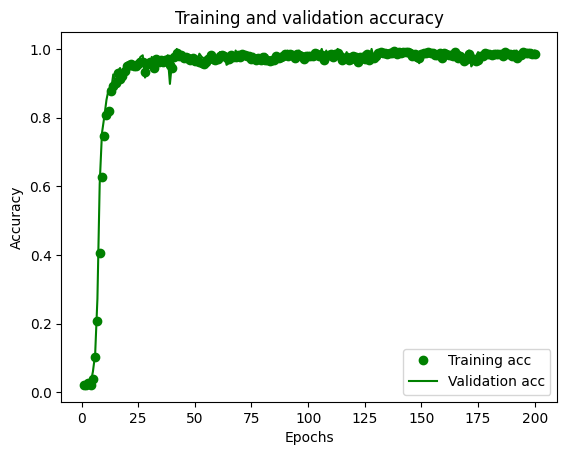

In [15]:
# Training accuracy
plt.plot(epochs, acc, 'go', label='Training acc')                 # "go" is for "green dot"
# Validation accuracy
plt.plot(epochs, val_acc, 'g', label='Validation acc')            # g is for "solid green line"
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Predict the Label


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


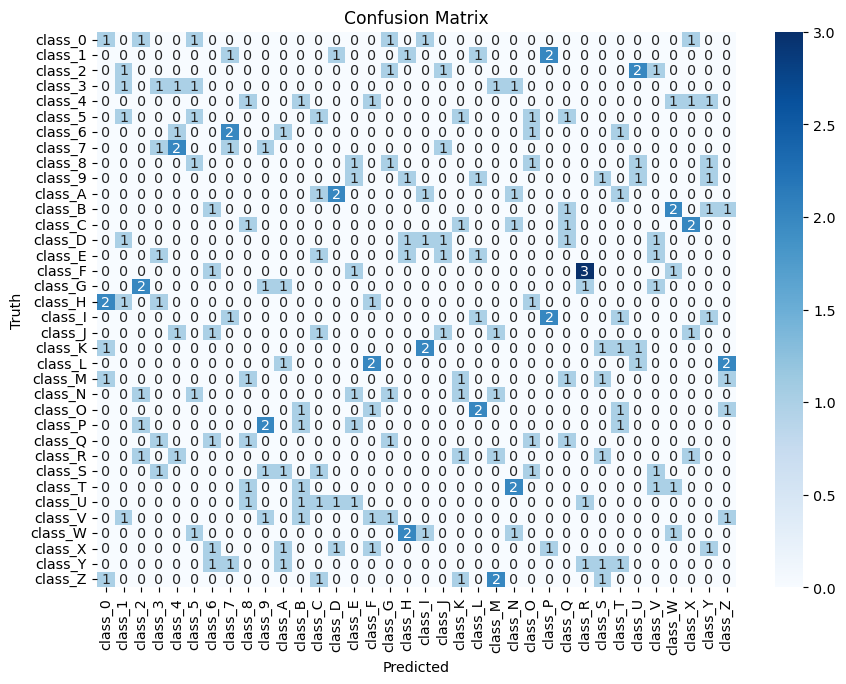

In [16]:
# Predict labels for the validation dataset
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=-1)

# Extract true labels from the validation generator
true_labels = validation_generator.classes

# Compute the confusion matrix
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convert confusion matrix to numpy array
cm = cm.numpy()

# Plot the confusion matrix
plt.figure(figsize=(10, 7), dpi=103)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices.keys(), 
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [17]:
print("Classification Report: \n", classification_report(true_labels, predicted_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.17      0.17      0.17         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         6
           5       0.17      0.17      0.17         6
           6       0.00      0.00      0.00         6
           7       0.17      0.17      0.17         6
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
  

#  Save and Load the model

In [18]:
# Save the complete model
model.save('saved_model/my_model.h5')

In [19]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('saved_model/my_model.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 24, 16)     │         7,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 24, 32)     │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 24, 64)     │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 44, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,325,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,797,398 (18.30 MB)

 Trainable params: 4,797,396 (18.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
Actual Label: 1
Predicted Label: 1


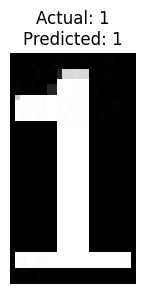

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to your image
img_path = '/kaggle/input/alpr-character-train/data/val/class_1/class_1_1.jpg'

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(44, 24), color_mode='grayscale'):
    img = image.load_img(img_path, target_size=target_size, color_mode=color_mode)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array  # No preprocessing since it's grayscale

# Preprocess the image
img_array = load_and_preprocess_image(img_path)

# Predict the label
y_predicted = loaded_model.predict(img_array)

# Get the predicted label index
y_predicted_label = np.argmax(y_predicted, axis=-1)[0]

# Get the predicted class name
predicted_class_name = reverse_class_labels[y_predicted_label]

# Extract the actual class name from the folder name
actual_class_name = class_labels[img_path.split('/')[-2]]

# Display the result
print(f'Actual Label: {actual_class_name}')
print(f'Predicted Label: {predicted_class_name}')

# Plot the image with actual and predicted labels
plt.figure(figsize=(3, 3))
plt.imshow(img_array[0].squeeze(), cmap='gray')
plt.title(f'Actual: {actual_class_name}\nPredicted: {predicted_class_name}', color='black')
plt.axis('off')
plt.show()

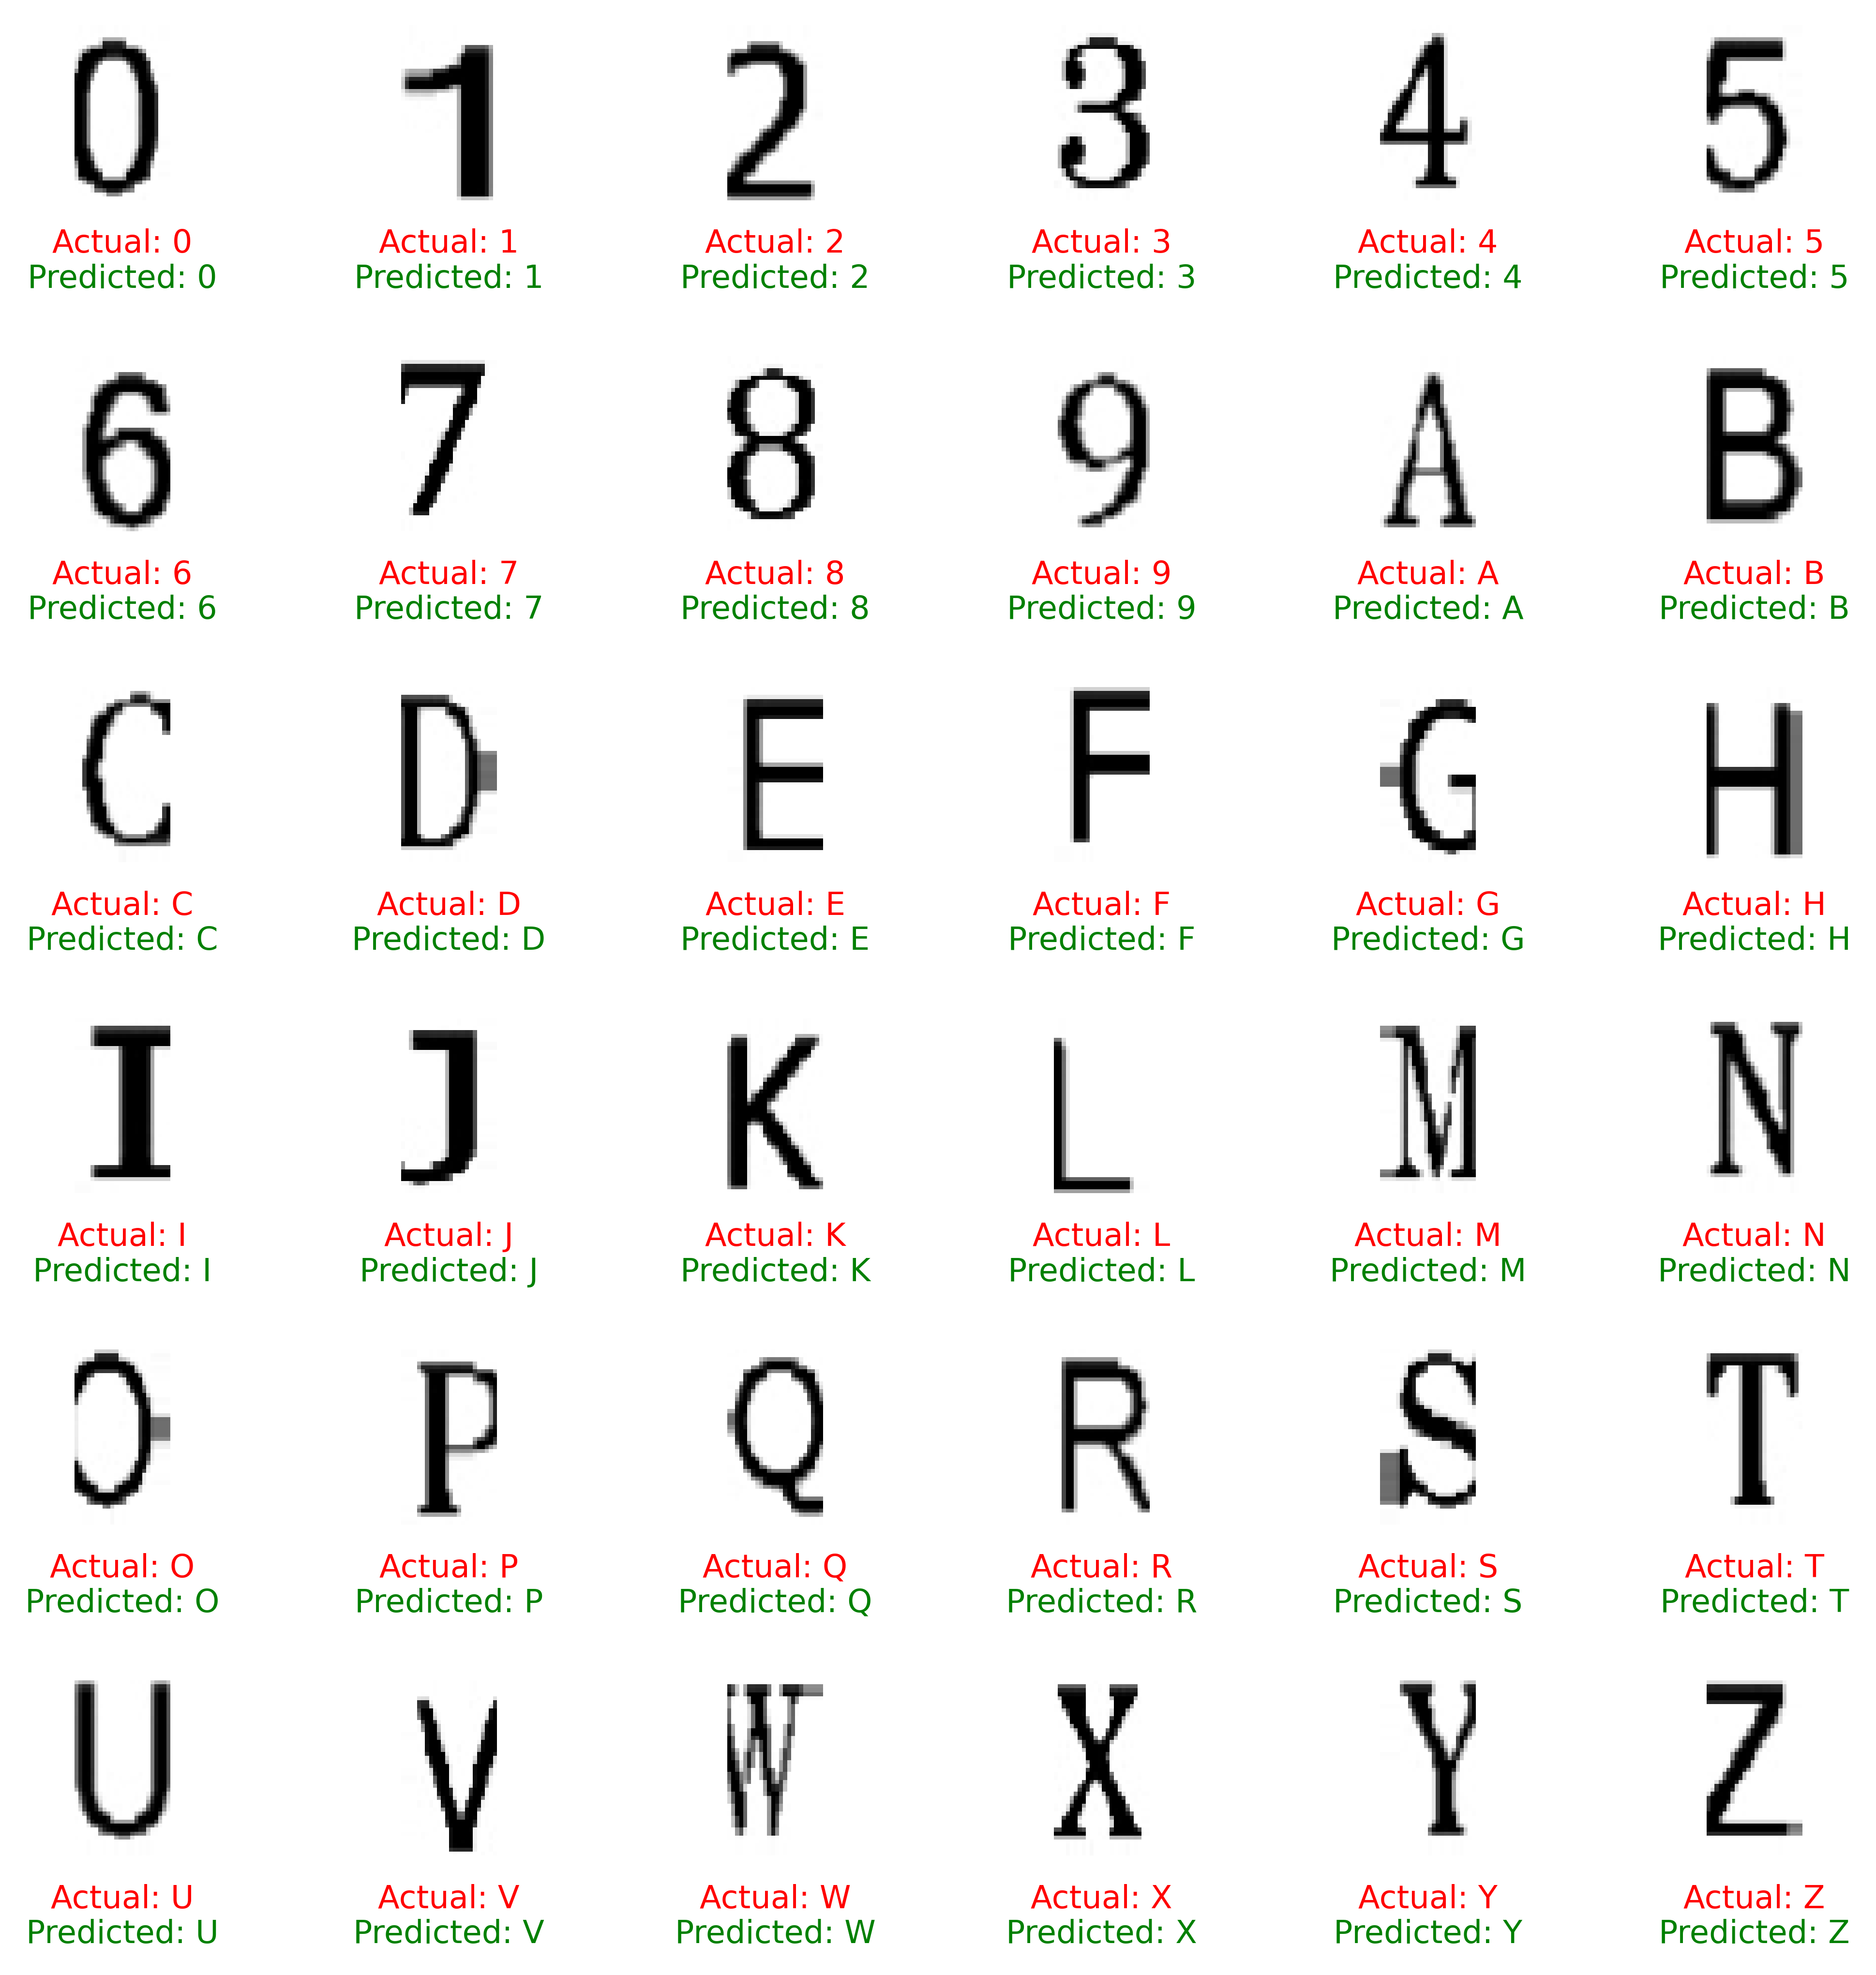

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Collect one image per class
class_images = {}
class_indices = []
for images, labels in validation_generator:
    for img, label in zip(images, labels):
        label = int(label)
        if label not in class_images:
            class_images[label] = img
            class_indices.append(label)
        if len(class_images) == len(class_labels):
            break
    if len(class_images) == len(class_labels):
        break

# Prepare a figure to plot images
plt.figure(figsize=(8, 8), dpi=523)  # Adjust figsize as needed
num_classes = len(class_labels)
grid_size = int(np.ceil(num_classes / 6))  # Adjust grid size based on number of classes

for i in range(num_classes):
    plt.subplot(grid_size, 6, i + 1)  # Adjust subplot grid size based on number of classes
    img = class_images.get(i)
    
    if img is not None:
        # Prepare the image for prediction
        img_array = np.expand_dims(img, axis=0)
        
        # Predict the class
        y_predicted = loaded_model.predict(img_array, verbose=0)
        y_predicted_label = np.argmax(y_predicted, axis=-1)[0]

        # Plot image
        plt.imshow(img.squeeze(), cmap=plt.cm.binary)  # Remove extra dimension if present
        
        # Get actual and predicted labels
        actual_label_text = reverse_class_labels[i]
        predicted_label_text = reverse_class_labels[y_predicted_label]
        
        # Add text annotations for actual and predicted labels with different colors
        plt.text(0.5, -0.3, f'Actual: {actual_label_text}', color='red', fontsize=9, ha='center', transform=plt.gca().transAxes)
        plt.text(0.5, -0.5, f'Predicted: {predicted_label_text}', color='green', fontsize=9, ha='center', transform=plt.gca().transAxes)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('off')

plt.tight_layout()
plt.show()